In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

title_text_bold = "Alsea_bay"                       #change the name of the estuary!
file_path = r'Data/02-2016-Alsea_bay.csv'           #FILE ROUTE
data = pd.read_csv(file_path)

#Read Input
def morquest(**kwargs):
    
    input = {
        'Ac': data['Ac'] * 1000000,                 #channel area, m2
        'Ai': data['Ai'] * 1000000,                 #intertidal area, m2
        'dH': data['dH'] / 1000,                    #tidal difference, m
        'Qr': data['Qr'],                           #river flow, m3/s
        'fQr': 0.0,                                 #factor for river flow
        'ssc': 0.1,                                 #river suspended sediment concentration, give always value to prevent div0, mg/l, g/m3
        'fssc': 0.00,                               #factor for ssc
        'slr': 0.53,                                #sea level rise after 'dur' years, m
        'slrtype': 'linear',                        #sea level rise type: 'accel'/'linear'
        'incAi': 0.00,                              #increase it area per year as percentage of intertidal area at t=0,

        #'at' : 40.0                                #intertidal area slr adaptation timescale, yr
        #'lit' : 3000                               #it area length perp to channel axis, m        
        
        'tr': 0.00,                                 #exchange from channel to shore as percentage of instantaneous total exchange
        'lsys': 5503.780,                           #empirically derived; system length scale; important to calculate connection length itarea to channel, m
        'cl': 1e6,                                  #coastline length, m
        'Vout': 1e10,                               #outside world sediment volumen
        'betas': data['slope'],                     #active shorezone slope [-]
        'cd': data['dc'],                           #closure depth, m
        'fd': 1.5,                                  #dune factor, m
        'du': 10,                                   #dune height above active zone, for Bruun rule, m

        'erc': 0.5,                                 #maximun river supply entrapment portion from river into channel, -
        'ecs': 0.5,                                 #maximum river supply entrapment portion from channel into shorelin, -
        'fis': 0.5,                                 #calibration factor for transport from river to it area under river sedsupply change, 1 menas all excess sedimen supply to itarea, [0 1], -
        'si': 0.105,                                #factor increasing intertidal area slope at edge for slr computations ; smaller value implies less intertidal area under slr. 1 = linear. (no effect if ~ >10), [0 inf], -
        'fs': 0.5,                                  #factor distributing it area deposition to it area width and channel slope, [0 1], -; 
        'faw': 0.5,                                 #factor diminishing fs and fis in case of lowering Qrc, [0 1], -; 

        'por': 0.4,                                 #porosity, -
        'rho': 2650,                                #sediment density, kg/m3
        'dur': 100,                                 #timespan calculation, yr
        'T': 43200,                                 #tidal period, s

        #Plotting parameters
        'plotme': 1,                        #make figures
        'plottimeres': 1,                   #plotting resolution, y
        'savemyplots': 0,                   #save plots to hardcopy
        'savemyplotsinfolder': './figs/'    #folder to save plots in
        }
    input.update(kwargs)

    #Verification of the list of data as INPUT
    return input    

input = morquest()      
# You can override the default values by passing keyword arguments to the function like this:
# input = morquest(Ac=100e6, slr=5, dur=5)

 #Efect of the sea Level
t = np.arange(input['dur'] + 1)
slrst = -1

if input['slrtype'] == 'accel':
    slr = input['slr'] * (np.sin(2 * np.pi / (4 * input['dur']) * t - np.pi / 2) + 1)
    slrr = np.diff(slr)
elif input['slrtype'] == 'linear':
    slrr = input['slr'] / input['dur'] * np.ones_like(t[:-1])
    slr = np.cumsum(slrr)
elif input['slrtype'] == 'timep':
    slr = np.zeros_like(t)
    slrst = 200
    slr[slrst:303] = input['slr'] * (np.sin(2 * np.pi / (4 * 100) * (np.arange(1, 104)) - np.pi / 2) + 1)
    slrr = np.diff(slr)
    
#Efect of the sediment concentration
#if isinstance(input['ssc'], (int, float)):
    #input['ssc'] = np.ones(input['dur'] + 1) * input['ssc']
tt = np.arange(0, input['dur']+1, input['plottimeres'])
ssc = np.zeros(len(tt))
ssc[0] = input['ssc']
for i in range(len(tt) - 1):  
    ssc[i+1] = ssc[i] + ssc[0]*input['fssc']*input['plottimeres']

#Efect of the River dischargue
Qr = np.zeros(len(tt))
Qr[0] = input['Qr']
for i in range(len(tt) - 1):  
    Qr[i+1] = Qr[i] + Qr[0]*input['fQr']*input['plottimeres']

itp = 1

# Assuming 'tt' has been calculated and defined
dAi_wh = np.zeros(len(tt))
dAi_sl = np.zeros(len(tt))
dAi = np.zeros(len(tt))
dAc = np.zeros(len(tt))
dVc_wh = np.zeros(len(tt))
dVc_sl = np.zeros(len(tt))
dVc = np.zeros(len(tt))
dVi_wh = np.zeros(len(tt))
dVi_sl = np.zeros(len(tt))
dVi = np.zeros(len(tt))
dVi_sed_wh = np.zeros(len(tt))
dVi_sed_sl = np.zeros(len(tt))
dVi_sed = np.zeros(len(tt))
dVs = np.zeros(len(tt))
dVd = np.zeros(len(tt))
dVout = np.zeros(len(tt))
erc = np.zeros(len(tt))
ds = np.zeros(len(tt))
dBr = np.zeros(len(tt))
dH = np.zeros(len(tt))

Ai = np.zeros(len(tt))
Ac = np.zeros(len(tt))
Ab = np.zeros(len(tt))
Vr = np.zeros(len(tt))
Vc = np.zeros(len(tt))
Vi = np.zeros(len(tt))
Vi_sed = np.zeros(len(tt))
Vs = np.zeros(len(tt))
Vd = np.zeros(len(tt))
Vout = np.zeros(len(tt))
hc = np.zeros(len(tt))
hcod = np.zeros(len(tt))
hi = np.zeros(len(tt))
hiod = np.zeros(len(tt))
P = np.zeros(len(tt))
Vceq = np.zeros(len(tt))
at = np.zeros(len(tt))

Qrc = np.zeros(len(tt))
Qri = np.zeros(len(tt))
Qcieq = np.zeros(len(tt))
Qci = np.zeros(len(tt))
Qci_at = np.zeros(len(tt))
Qcdeq = np.zeros(len(tt))
Qcd = np.zeros(len(tt))
Qcs = np.zeros(len(tt))
Qsd = np.zeros(len(tt))
Qco = np.zeros(len(tt))
Qdo = np.zeros(len(tt))
Qso = np.zeros(len(tt))

# Initial parameter values
Ai[0] = input['Ai']
dH[0] = input['dH']
#Initial parameter values

Ab = input['Ac'] + input['Ai']                                      #basin area, m2
Qssec = Qr* ssc                                  #sediment supply, kg/s
Qs = Qssec * 3600 * 24 * 365 / input['rho'] / (1 - input['por'])    #yearly sediment supply volume incl porosity, m3/yr
Vr[0] = Qr[0] * ssc[0]                                 #river sediment volume inflow
Vi[0] = 0.5 * input['Ai'] * input['dH']                              #intertidal water volume, m3
Vi_sed[0] = Vi[0]                                                    #intertidal area sediment volume, m3
P[0] = input['dH'] * input['Ac'] + Vi[0]                             #tidal prism, m3
vca = 65e-6
vce = 1.55
Vceq[0] = vca * P[0]**vce                                           #initial channel water volume, m3

Vc[0] = Vceq[0]                                                      #equilibrium channel water volume, m3
vda = 2.9e-3
vde = 1.23
Vd[0] = vda * P[0]**vde                                              #delta sediment volume, m3
hi[0] = Vi[0] / input['Ai']                                          #mean water depth at intertidal area, m
hc[0] = Vc[0] / input['Ac']                                          #mean water depth in channel area, m
Ai[0] = input['Ai']
Ac[0] = input['Ac']
Vs[0] = 1.5 * input['cl'] * 0.5 * input['cd']**2 / input['betas']
Vout[0] = input['Vout']

## Update of the equation of Adaptation Time Scale
at[0] = input['T'] * input['lsys'] / input['dH'] / (365 * 24 * 3600) # adaptation timescale, yr  
#at[0] = 0.75 * (Ac[0]  + Ai[0])

Qrc = Qs                                                            # sedtransport river-channel /yr, m3
Qci[0] = 0                                                           # sedtransport channel-intertidal /yr, m3 ......................!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Qcieq[0] = slrr[0] * Ai[0]                                           # channel-intertidalarea sediment transport required to keep up with SLR
Qcdeq[0] = 0                                                        # based on delta sediment volume required to meet P, m3
Qcd[0] = 0                                                         # sedtransport channel-delta /yr, m3
Qcs[0] = Qrc[0]                                                     # sedtransport channel-shore /yr, m3
Qsd[0] = 0                                                          # sedtransport shore-delta /yr, m3
Qco[0] = 0                                                           # sedtransport channel-out /yr, m3
Qdo[0] = 0                                                           # sedtransport delta-out /yr, m3
Qso[0] = Qrc[0]                                                      # sedtransport shore-out /yr, m3
Qri[0] = 0                                                           # sedtransport river-intertidal /yr, m3

for yr in range(input['dur']-1):
    dAi_sl[yr] = -slrr[yr] * Ai[yr] / input['dH'] / input['si']
    dAi[yr] = input['incAi'] * Ai[max(1, yr - 1)]                                                                   + dAi_sl[yr] + dAi_wh[yr]
    dAc[yr] =                                                                                                       - dAi_sl[yr] - dAi_wh[yr]
    dVc_sl[yr] = -input['dH'] * dAi_sl[yr] * 0.5 * (1 - slrr[yr] / input['dH']) + (Ac[yr] - dAi[yr]) * slrr[yr]
    dVc[yr] = -Qrc[yr] + Qci_at[yr] + Qcd[yr] + Qcs[yr] + Qco[yr]                                                   + dVc_sl[yr] + dVc_wh[yr]
    dVi_sl[yr] = input['dH'] * dAi_sl[yr] * (1 - 0.5 * slrr[yr] / input['dH']) + (Ai[yr] + dAi[yr]) * slrr[yr]
    dVi[yr] = -Qci_at[yr]                                                                                           + dVi_sl[yr] + dVi_wh[yr]
    dVi_sed_sl[yr] = -Ai[yr] * slrr[yr] + 0.5 * dAi[yr] * slrr[yr]
    dVi_sed[yr] = Qci_at[yr]                                                                                        + dVi_sed_sl[yr] + dVi_sed_wh[yr]

    dVs[yr] = Qcs[yr] - Qsd[yr] - Qso[yr]
    dVd[yr] = Qcd[yr] + Qsd[yr] - Qdo[yr]
    dVout[yr] = Qco[yr] + Qdo[yr] + Qso[yr]

    ds[yr] = dVs[yr] / (input['cl'] * input['cd'])
    dBr[yr] = -slrr[yr] * input['cd'] / input['betas'] / (input['cd'] + input['du'])    #Bruun rule

    # Prevent negative volumes
    if dAi[yr] <= -Ai[yr]:
        dAi[yr] = -Ai[yr]
    if dAc[yr] <= -Ac[yr]:
        dAc[yr] = -Ac[yr]
    if dVc[yr] <= -Vc[yr]:
        dVc[yr] = -Vc[yr]
    if dVi[yr] <= -Vi[yr]:
        dVi[yr] = -Vi[yr]

    if itp == 0 or (dVi_sed[yr] <= -Vi_sed[yr]).all() or (hi[yr] >= input['dH']).all():
        itp = 0
        dVi_sed[yr] = -Vi_sed[yr]
        Vc[yr] = Vc[yr] + Ai[yr] * hi[yr]
        Ai[yr] = 0
        Ac[yr] = Ab
        hi[yr] = 0
        hiod[yr] = 0
        Vi[yr] = 0
        Qci[yr] = 0
        Qri[yr] = 0

    if dVs[yr] <= -Vs[yr]:
        dVs[yr] = -Vs[yr]
    if dVd[yr] <= -Vd[yr]:
        dVd[yr] = -Vd[yr]
    if dVout[yr] <= -Vout[yr]:
        dVout[yr] = -Vout[yr]

    Ai[yr + 1] = Ai[yr] + dAi[yr]
    Ac[yr + 1] = Ac[yr] + dAc[yr]
    Vr[yr + 1] = Vr[yr] + Qrc[yr]
    Vc[yr + 1] = Vc[yr] + dVc[yr]
    Vi[yr + 1] = Vi[yr] + dVi[yr]
    Vi_sed[yr + 1] = Vi_sed[yr] + dVi_sed[yr]
    Vs[yr + 1] = Vs[yr] + dVs[yr]
    Vd[yr + 1] = Vd[yr] + dVd[yr]
    Vout[yr + 1] = Vout[yr] + dVout[yr]

    if Ac[yr + 1] <= 0:
        hc[yr + 1] = 0
    else:
        hc[yr + 1] = Vc[yr + 1] / Ac[yr + 1]

    if Ai[yr + 1] <= 0:
        hi[yr + 1] = 0
    else:
        hi[yr + 1] = Vi[yr + 1] / Ai[yr + 1]

    if slrr[yr + 1] == 0:
        hiod[yr + 1] = 0
    else:
        hiod[yr + 1] = hi[yr + 1] - hi[slrst+1]

    P[yr + 1] = input['dH'] * Ac[yr + 1] + Vi[yr + 1]
    Vceq[yr + 1] = vca * P[yr + 1]**vce                     # channel water volume, m3, see Eysink 1990
    hcod[yr + 1] = Vc[yr + 1] / Ac[yr + 1] - Vceq[yr + 1] / Ac[yr + 1]
    # erc[yr + 1] = min(
    #     1 - (dVc[yr] + Qrc[yr] - Qci[yr] + input['fis'] * Qri[yr] - input['tr'] * (Vceq[yr] - Vc[yr]) - dVc_sl[yr] - dVc_wh[yr]) / Qrc[yr],
    #     input['erc'])  # min of no dVc and input['erc']
    # if Vceq[yr] - Vc[yr] >= 0:
    #     erc[yr + 1] = 0

    if Qrc[yr + 1] >= Qrc[yr]:
        Qri[yr + 1] = input['fis'] * (Qrc[yr + 1] - Qrc[yr])                    # *(abs(Qrc[yr + 1] - Qrc[yr]) / Qrc[yr])
    else:
        Qri[yr + 1] = input['faw'] * input['fis'] * (Qrc[yr + 1] - Qrc[yr])     # *(abs(Qrc[yr + 1] - Qrc[yr]) / Qrc[yr])

    Qcieq[yr + 1] = slrr[yr] * Ai[yr]                                           # channel-intertidal area sediment transport required to keep up with SLR
    
    
    ## Update of the equation of Adaptation Time Scale
    at[yr + 1] = (hi[yr + 1] / hi[0]) ** 2 * input['T'] * input['lsys'] / input['dH'] / (365 * 24 * 3600)  # adaptation timescale, yr   #################################!!!!!!!!!!!!!!!!!!!!!
    #at[yr + 1] = (hi[yr + 1] / hi[0]) ** 2 * (0.75 * Ac[yr + 1] + 0.75 * Ai[yr + 1])
    ####
    if yr - slrst >= 0:
        if at[yr + 1] != 0:
            Qci_at[yr + 1] = Qcieq[yr] * (1 - np.exp(-(yr - slrst) / at[yr + 1]))
        else:
            Qci_at[yr + 1] = Qcieq[yr]  # Set Qci_at directly to Qcieq when at[yr + 1] is zero
    else:
        Qci_at[yr + 1] = 0
    ####
    
    Qci[yr + 1] = Qci_at[yr + 1] + Qri[yr + 1]
    Qcdeq[yr + 1] = vda * (P[yr + 1]) ** vde - vda * (P[yr]) ** vde             # based on delta sediment volume required to meet P, m3, see Eysink 1990
    Qcd[yr + 1] = Qcdeq[yr + 1]
    Qcs[yr + 1] = (1 - erc[yr + 1]) * Qrc[yr + 1] - input['fis'] * Qri[yr + 1] + input['tr'] * (Vceq[yr + 1] - Vc[yr + 1])
    Qsd[yr + 1] = 0
    Qco[yr + 1] = 0
    Qdo[yr + 1] = 0

    ## height-width correction
    if yr >= 2:
        if hi[yr + 1] == 0 or hi[yr + 1] == 0 or hc[yr] == 0:
            pass
        else:
            if Qri[yr + 1] / Ai[yr + 1] >= 0:
                if Qri[yr + 1] / Ai[yr + 1] == 0:
                    pass
                else:
                    dAi_wh[yr + 1] = Qri[yr + 1] * input['fs'] / hc[yr]
                    dVi_wh[yr + 1] = input['dH'] * dAi_wh[yr + 1] - Qri[yr + 1] * (1 - input['fs'])
                    dVi_sed_wh[yr + 1] = Qri[yr + 1] * (1 - input['fs']) + dAi_wh[yr + 1] * input['dH'] * input['si'] / Ai[yr] * (0.5 * dAi_wh[yr + 1] + Ai[yr])
                    dVc_wh[yr + 1] = -dAi_wh[yr + 1] * (input['dH'] + hc[yr])
            else:
                dAi_wh[yr + 1] = Qri[yr + 1] * input['faw'] * input['fs'] / hc[yr]
                dVi_wh[yr + 1] = input['dH'] * dAi_wh[yr + 1] - Qri[yr + 1] * (1 - input['faw'] * input['fs'])
                dVi_sed_wh[yr + 1] = Qri[yr + 1] * (1 - input['faw'] * input['fs']) + dAi_wh[yr + 1] * input['dH'] * input['si'] / Ai[yr] * (0.5 * dAi_wh[yr + 1] + Ai[yr])
                dVc_wh[yr + 1] = -dAi_wh[yr + 1] * (input['dH'] + hc[yr])

    ## prevent transport from empty volumes
    if Qcs[yr+1] >= 0:
        Qso[yr+1] = (1 - input['ecs']) * Qcs[yr+1]      # entrapment in shore for positive Qcs
    else:
        Qso[yr+1] = (input['ecs']) * Qcs[yr+1]          # entrapment in shore for negative Qcs

    if Vout[yr+1] <= 0:
        Vout[yr+1] = 0
        if Qso[yr+1] < 0:
            Qso[yr+1] = 0                             # no transport from out to shore if no out volume

    if Vs[yr+1] <= 0:
        Vs[yr+1] = 0
        if Qcs[yr+1] <= 0:
            Qcs[yr+1] = 0                             # no transport from shore to channel if no shore volume
        if Qso[yr+1] >= Vs[yr+1] + Qcs[yr+1]:
            Qso[yr+1] = Qcs[yr+1]                       # transport from shore equal to shore if no shore volume

    if Vi[yr+1] <= 0 or Ai[yr+1] <= 0:
        Vi[yr+1] = 0
        Ai[yr+1] = 0
        hi[yr+1] = 0
        hiod[yr+1] = 0
        Vi_sed[yr+1] = 0
        Ac[yr+1] = Ac[yr]
        if -Qci[yr] + dVi_sl[yr] + dVi_wh[yr] <= 0:
            Qci[yr] = dVi_sl[yr] + dVi_wh[yr]

    if Vc[yr+1] <= 0:
        Vc[yr+1] = 0
        if -Qrc[yr] + Qci[yr] + Qcd[yr] + Qcs[yr] + Qco[yr] + dVc_sl[yr] + dVc_wh[yr] <= 0:
            Qrc[yr] = Qci[yr] + Qcd[yr] + Qcs[yr] + Qco[yr] + dVc_sl[yr] + dVc_wh[yr]  # no transport from intertidal to channel if no channel volume
        Ai[yr+1] = Ai[yr]
        Ac[yr+1] = 0
        hc[yr+1] = 0
        hcod[yr+1] = 0

#final timestep
yr = input['dur']-1

dAi_sl[yr] = -slrr[yr] * Ai[yr] / input['dH'] / input['si']
dAi[yr] = input['incAi'] * Ai[max(1, yr - 1)]                                                                   + dAi_sl[yr] + dAi_wh[yr]
dAc[yr] =                                                                                                       -dAi_sl[yr] - dAi_wh[yr]
dVc_sl[yr] = -input['dH'] * dAi_sl[yr] * 0.5 * (1 - slrr[yr] / input['dH']) + (Ac[yr] - dAi[yr]) * slrr[yr]
dVc[yr] = -Qrc[yr] + Qci_at[yr] + Qcd[yr] + Qcs[yr] + Qco[yr]                                                   + dVc_sl[yr] + dVc_wh[yr]
dVi_sl[yr] = input['dH'] * dAi_sl[yr] * (1 - 0.5 * slrr[yr] / input['dH']) + (Ai[yr] + dAi[yr]) * slrr[yr]
dVi[yr] = -Qci_at[yr]                                                                                           + dVi_sl[yr] + dVi_wh[yr]
dVi_sed_sl[yr] = -Ai[yr] * slrr[yr] + 0.5 * dAi[yr] * slrr[yr]
dVi_sed[yr] = Qci_at[yr]                                                                                        + dVi_sed_sl[yr] + dVi_sed_wh[yr]

dVs[yr] = Qcs[yr] - Qsd[yr] - Qso[yr]
dVd[yr] = Qcd[yr] + Qsd[yr] - Qdo[yr]
dVout[yr] = Qco[yr] + Qdo[yr] + Qso[yr]

ds[yr] = dVs[yr] / (input['cl'] * input['cd'])
dBr[yr] = -slrr[yr] * input['cd'] / input['betas'] / (input['cd'] + input['du'])    #Bruun rule

# Prevent negative volumes
if dAi[yr] <= -Ai[yr]:
    dAi[yr] = -Ai[yr]
if dAc[yr] <= -Ac[yr]:
    dAc[yr] = -Ac[yr]
if dVc[yr] <= -Vc[yr]:
    dVc[yr] = -Vc[yr]
if dVi[yr] <= -Vi[yr]:
    dVi[yr] = -Vi[yr]
if dVi_sed[yr] <= -Vi_sed[yr]:
    dVi_sed_sl[yr] = -Qci[yr]
    dVi_sed[yr] = 0
if dVs[yr] <= -Vs[yr]:
    dVs[yr] = -Vs[yr]
if dVd[yr] <= -Vd[yr]:
    dVd[yr] = -Vd[yr]
if dVout[yr] <= -Vout[yr]:
    dVout[yr] = -Vout[yr]

Ai[yr + 1] = Ai[yr] + dAi[yr]
Ac[yr + 1] = Ac[yr] + dAc[yr]
Vr[yr + 1] = Vr[yr] + Qrc[yr]
Vc[yr + 1] = Vc[yr] + dVc[yr]
Vi[yr + 1] = Vi[yr] + dVi[yr]
Vi_sed[yr + 1] = Vi_sed[yr] + dVi_sed[yr]
Vs[yr + 1] = Vs[yr] + dVs[yr]
Vd[yr + 1] = Vd[yr] + dVd[yr]
Vout[yr + 1] = Vout[yr] + dVout[yr]

hc[yr + 1] = Vc[yr + 1] / Ac[yr]
hi[yr + 1] = Vi[yr + 1] / Ai[yr + 1]
hiod[yr + 1] = hi[yr + 1] - hi[0]

####add 31/08/2023
if Qrc[yr + 1] >= Qrc[yr]:
     Qri[yr + 1] = input['fis'] * (Qrc[yr + 1] - Qrc[yr])                    # *(abs(Qrc[yr + 1] - Qrc[yr]) / Qrc[yr])
else:
    Qri[yr + 1] = input['faw'] * input['fis'] * (Qrc[yr + 1] - Qrc[yr])     # *(abs(Qrc[yr + 1] - Qrc[yr]) / Qrc[yr])
########
    
## Update at
at[yr + 1] = (hi[yr + 1] / hi[0]) ** 2 * input['T'] * input['lsys'] / input['dH'] / (365 * 24 * 3600)  # adaptation timescale, yr   #################################!!!!!!!!!!!!!!!!!!!!!
#at[yr + 1] = (hi[yr + 1] / hi[0]) ** 2 * (0.75 * (Ac[yr + 1] + Ai[yr + 1]))

if yr - slrst >= 0:
    if at[yr + 1] != 0:
        Qci_at[yr + 1] = Qcieq[yr] * (1 - np.exp(-(yr - slrst) / at[yr + 1]))
    else:
        Qci_at[yr + 1] = Qcieq[yr]  # Set Qci_at directly to Qcieq when at[yr + 1] is zero
else:
    Qci_at[yr + 1] = 0
        
Qci[yr + 1] = Qci_at[yr + 1] + Qri[yr + 1]
##############################################
P[yr + 1] = input['dH'] * Ac[yr + 1] + Vi[yr + 1]
Vceq[yr + 1] = vca * P[yr + 1] ** vce
hcod[yr + 1] = Vc[yr + 1] / Ac[yr + 1] - Vceq[yr + 1] / Ac[yr + 1]
    
##add 31/08/2023
Qcdeq[yr + 1] = vda * (P[yr + 1]) ** vde - vda * (P[yr]) ** vde             # based on delta sediment volume required to meet P, m3, see Eysink 1990
Qcd[yr + 1] = Qcdeq[yr + 1]
####

## correct Qcs and Qso  31/08/2023
Qcs[yr + 1] = (1 - erc[yr + 1]) * Qrc[yr + 1] - input['fis'] * Qri[yr + 1] + input['tr'] * (Vceq[yr + 1] - Vc[yr + 1])
if Qcs[yr+1] >= 0:
    Qso[yr+1] = (1 - input['ecs']) * Qcs[yr+1]      # entrapment in shore for positive Qcs
else:
    Qso[yr+1] = (input['ecs']) * Qcs[yr+1]          # entrapment in shore for negative Qcs
##

sedVc = np.cumsum(Qrc) - np.cumsum(Qci) - np.cumsum(Qcd) - np.cumsum(Qcs) - np.cumsum(Qco)
sedVi = np.cumsum(dVi_sed)
sedVd = Vd - Vd[0]
sedVs = Vs - Vs[0]
sedVr = Vr - Vr[0]
sedVout = Vout - Vout[0]

dVc_sl[yr] = -input['dH'] * dAi_sl[yr] * 0.5 * (1 - slrr[yr] / input['dH']) + (Ac[yr] - dAi[yr]) * slrr[yr]
dVc[yr] = -Qrc[yr] + Qci[yr] + Qcd[yr] + Qcs[yr] + Qco[yr]                                                   + dVc_sl[yr]

dVi_sl[yr] = input['dH'] * dAi_sl[yr] * (1 - 0.5 * slrr[yr] / input['dH']) + (Ai[yr] + dAi[yr]) * slrr[yr]
dVi[yr] = -Qci[yr]                                                                                           + dVi_sl[yr] 

dVi_sed_sl[yr] = -Ai[yr] * slrr[yr] + 0.5 * dAi[yr] * slrr[yr]
dVi_sed[yr] = Qci[yr]                                                                                        + dVi_sed_sl[yr]

dVs[yr] = Qcs[yr] - Qsd[yr] - Qso[yr]
dVd[yr] = Qcd[yr] + Qsd[yr] - Qdo[yr]
dVout[yr] = Qco[yr] + Qdo[yr] + Qso[yr]

ds[yr] = dVs[yr] / (input['cl'] * input['cd'])
dBr[yr] = slrr[yr] * input['cd'] / input['betas'] / (input['cd'] + input['du'])    #Bruun rule

# Output
output = {}
output['slrtype'] = input['slrtype']
output['incAi'] = input['incAi']
output['lsys'] = input['lsys']
output['tr'] = input['tr']
output['cl'] = input['cl']
output['Vout'] = input['Vout']
output['slope'] = input['betas']
output['cd'] = input['cd']
output['erc'] = input['erc']
output['ecs'] = input['ecs']
output['fis'] = input['fis']
output['si'] = input['si']
output['ssc'] = input['ssc']
output['fd'] = input['fd']
output['fs'] = input['fs']
output['faw'] = input['faw']
output['du'] = input['du']

output['yr'] = np.arange(0, input['dur'] + 1)
output['slr'] = slr
output['slrr'] = slrr
output['dAi'] = dAi
output['dVc'] = dVc
output['dVc_sl'] = dVc_sl
output['dVc_wh'] = dVc_wh
output['dVi'] = dVi
output['dVi_sl'] = dVi_sl
output['dVi_wh'] = dVi_wh
output['dVs'] = dVs
output['dVd'] = dVd
output['dVout'] = dVout
output['dVi_sed_sl'] = dVi_sed_sl
output['dVi_sed_wh'] = dVi_sed_wh
output['dVi_sed'] = dVi_sed
output['ds'] = ds
output['dBr'] = dBr
output['at'] = at

output['Ai'] = Ai
output['Ac'] = Ac
output['Ab'] = output['Ai'] + output['Ac']
output['Vr'] = Vr
output['Vc'] = Vc
output['Vi'] = Vi
output['Vs'] = Vs
output['Vd'] = Vd
output['Vout'] = Vout
output['hc'] = hc
output['hi'] = hi
output['hiod'] = hiod
output['hcod'] = hcod
output['P'] = P
output['Vceq'] = Vceq
output['sedVc'] = sedVc
output['sedVi'] = Vi_sed
output['sedVd'] = sedVd
output['sedVs'] = sedVs
output['sedVr'] = sedVr
output['sedVout'] = sedVout

output['Qssec'] = Qssec
output['Qrc'] = Qrc
output['Qcd'] = Qcd
output['Qci'] = Qci
output['Qri'] = Qri
output['Qcs'] = Qcs
output['Qso'] = Qso

scipy.io.savemat(f'Output/{title_text_bold}.mat', output)


C:\Users\mre003\AppData\Local\Temp\ipykernel_9456\3968165503.py:91: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  Qr[0] = input['Qr']
C:\Users\mre003\AppData\Local\Temp\ipykernel_9456\3968165503.py:151: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  Ai[0] = input['Ai']
C:\Users\mre003\AppData\Local\Temp\ipykernel_9456\3968165503.py:152: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dH[0] = input['dH']
C:\Users\mre003\AppData\Local\Temp\ipykernel_9456\3968165503.py:159: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  Vi[0] = 0.5 * input['Ai'] * input['dH']                              #intertidal wate

In [2]:
Last_value_Ac = Ac[-1]/1000000
Last_value_Ai = Ai[-1]/1000000
Last_value_at = at[-1]/1000000

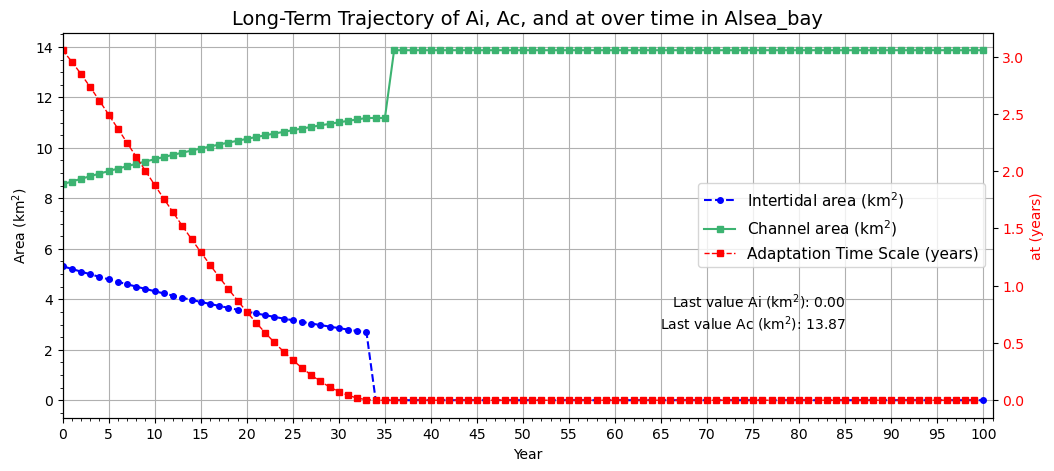

In [3]:
a1 = max(slr)/(input['dur'] + 1)
slr2 = np.arange(0,max(slr),a1)

a = max(output['yr'])+1 #Limit of the plot

# Create a figure and axis for the primary scale (left)
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(111)

# Add text to the plot indicating the last values
plt.text(
    85,  # X-coordinate of the text
    2,  # Y-coordinate of the text
    f'Last value Ai (km$^2$): {Last_value_Ai:.2f}\nLast value Ac (km$^2$): {Last_value_Ac:.2f}\n',  # Text content
    fontsize=10,  # Fontsize of the text
    verticalalignment='bottom',  # Vertical alignment of the text
    horizontalalignment='right'   # Horizontal alignment of the text
)

ax1.plot(output['yr'], Ai/1000000, label = 'Intertidal area (km$^2$)', linewidth=1.5, linestyle = '--', marker = 'o', markersize=4, color ="b")
ax1.plot(output['yr'], Ac/1000000, label = 'Channel area (km$^2$)', linewidth=1.5, linestyle = '-', marker = 's', markersize=4, color ="#3CB371")
ax1.set_xlabel('Year')
ax1.set_ylabel('Area (km$^2$)')
ax1.tick_params(axis='y')
plt.grid()
plt.minorticks_on()
plt.xticks(np.arange(0,a,5))
plt.xlim(0,a)

# Create a secondary axis for the second scale (right)
ax2 = ax1.twinx()
ax2.plot(output['yr'], at, label = 'Adaptation Time Scale (years)', linewidth=1, linestyle = '--', marker = 's', markersize=4, color= 'r')
ax2.set_ylabel('at (years)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add legends for both scales
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
ax1.legend(lines, labels, loc='best', fontsize=11)


plt.title(f'Long-Term Trajectory of Ai, Ac, and at over time in {title_text_bold}', fontsize=14, color="black")
plt.savefig(f'Output/02-Long-Term Trajectory of Ai, Ac and at over time in {title_text_bold}.png', bbox_inches='tight')

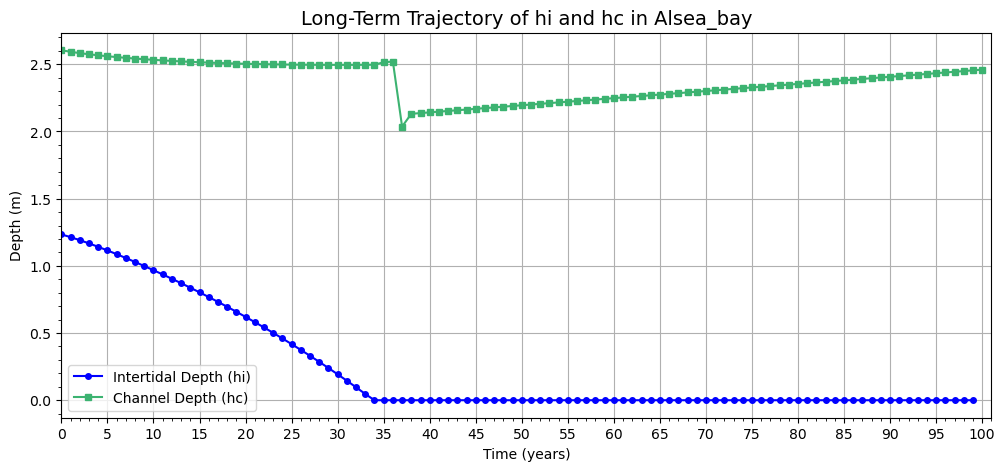

In [4]:
#PLOTEO 
fig = plt.figure(figsize=(12,5))
#plt.subplot(231)
plt.plot(output['yr'], hi, label = 'Intertidal Depth (hi)', color='b',linewidth = 1.5, linestyle = '-',marker='o', markersize=4)
plt.plot(output['yr'], hc, label = 'Channel Depth (hc)', color='#3CB371',linewidth = 1.5, linestyle = '-',marker='s', markersize=4)
#plt.plot(output['yr'], slr2, label = 'Sea Level',color='#00008B',linewidth = 1.5, linestyle = '-',marker='v', markersize=4)
plt.legend([], borderpad=0.5, labelspacing=1.0, fontsize=15)

plt.ylabel('Depth (m)')
plt.xlabel('Time (years)')
plt.minorticks_on()
plt.xticks(np.arange(0,a,5))
plt.xlim(0,a)
plt.legend()
plt.grid(True)
plt.title(f'Long-Term Trajectory of hi and hc in {title_text_bold}', fontsize=14, color="black")
plt.savefig(f'Output/00-Long-Term Trajectory of hi and hc in {title_text_bold}.png', bbox_inches='tight')

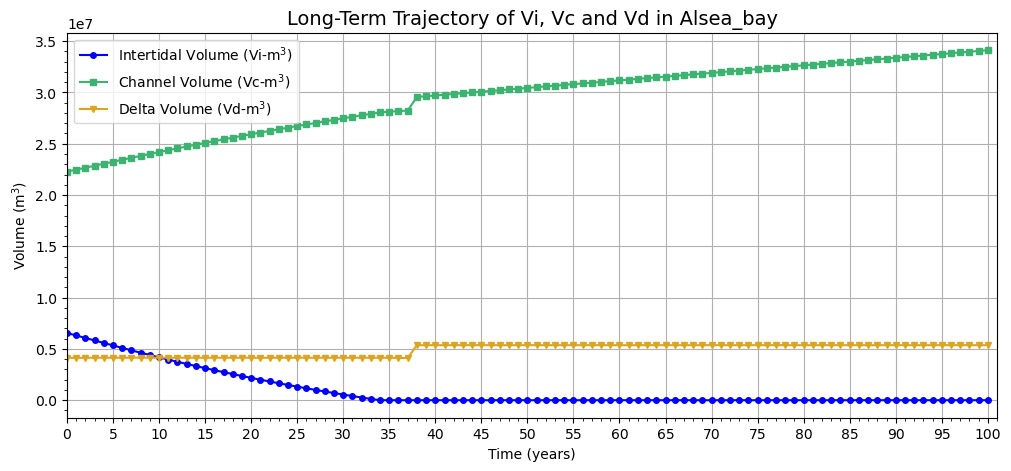

In [5]:
#PLOTEO 
fig = plt.figure(figsize=(12,5))
#plt.subplot(231)
plt.plot(output['yr'], Vi, label = 'Intertidal Volume (Vi-m$^3$)', color='b',linewidth = 1.5, linestyle = '-',marker='o', markersize=4)
plt.plot(output['yr'], Vc, label = 'Channel Volume (Vc-m$^3$)', color='#3CB371',linewidth = 1.5, linestyle = '-',marker='s', markersize=4)
plt.plot(output['yr'], Vd, label = 'Delta Volume (Vd-m$^3$)',color='#DAA520',linewidth = 1.5, linestyle = '-',marker='v', markersize=4)
#plt.plot(output['yr'], Vs, label = 'Shoreline Volume (Vs)',color='#8B008B',linewidth = 1.5, linestyle = '-',marker='*', markersize=4)
plt.legend([], borderpad=0.5, labelspacing=1.0, fontsize=15)

plt.ylabel('Volume (m$^3$)')
plt.xlabel('Time (years)')
plt.minorticks_on()
plt.xticks(np.arange(0,a,5))
plt.xlim(0,a)
plt.legend()
plt.grid(True)
plt.title(f'Long-Term Trajectory of Vi, Vc and Vd in {title_text_bold}', fontsize=14, color="black")
plt.savefig(f'Output/00-Long-Term Trajectory of Vi, Vc and Vd in {title_text_bold}.png', bbox_inches='tight')

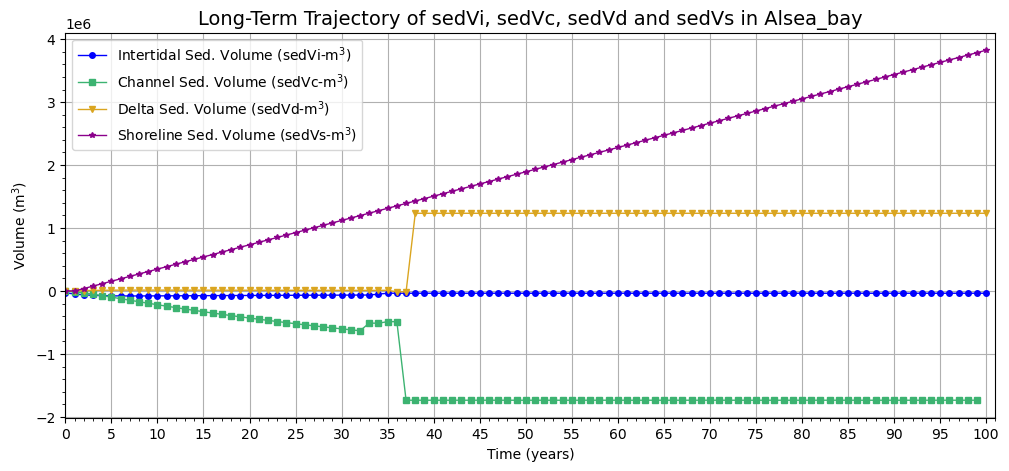

In [6]:
#PLOTEO 
fig = plt.figure(figsize=(12,5))
#plt.subplot(231)
plt.plot(output['yr'], sedVi, label = 'Intertidal Sed. Volume (sedVi-m$^3$)', color='b',linewidth = 1., linestyle = '-',marker='o', markersize=4)
plt.plot(output['yr'], sedVc, label = 'Channel Sed. Volume (sedVc-m$^3$)', color='#3CB371',linewidth = 1., linestyle = '-',marker='s', markersize=4)
plt.plot(output['yr'], sedVd, label = 'Delta Sed. Volume (sedVd-m$^3$)',color='#DAA520',linewidth = 1., linestyle = '-',marker='v', markersize=4)
plt.plot(output['yr'], sedVs, label = 'Shoreline Sed. Volume (sedVs-m$^3$)',color='#8B008B',linewidth = 1., linestyle = '-',marker='*', markersize=4)
plt.legend([], borderpad=0.5, labelspacing=1.0, fontsize=15)

plt.ylabel('Volume (m$^3$)')
plt.xlabel('Time (years)')
plt.minorticks_on()
plt.xticks(np.arange(0,a,5))
plt.xlim(0,a)
plt.legend()
plt.grid(True)

plt.title(f'Long-Term Trajectory of sedVi, sedVc, sedVd and sedVs in {title_text_bold}', fontsize=14, color="black")
plt.savefig(f'Output/00-Long-Term Trajectory of sedVi, sedVc, sedVd and sedVs in {title_text_bold}.png', bbox_inches='tight')

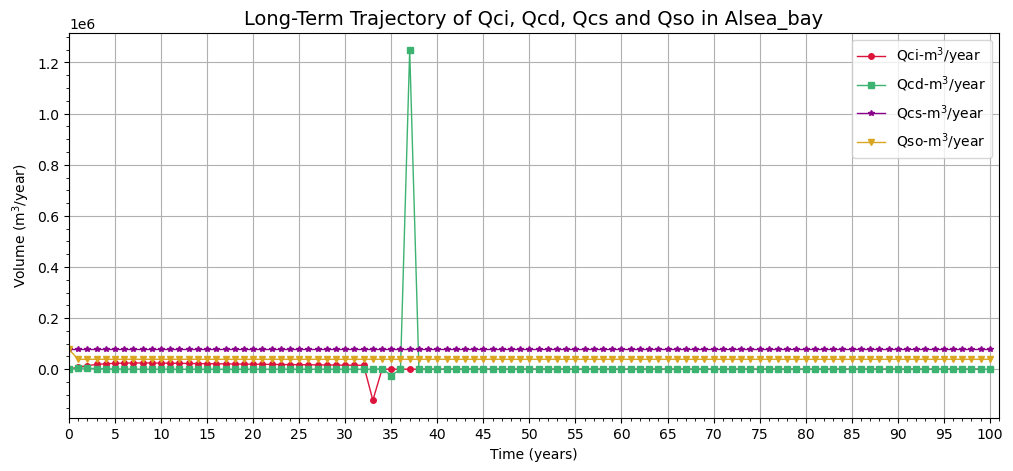

In [7]:
#PLOTEO 
fig = plt.figure(figsize=(12,5))
#plt.subplot(231)
plt.plot(output['yr'], Qci, label = 'Qci-m$^3$/year', color='#DC143C',linewidth = 1., linestyle = '-',marker='o', markersize=4)
plt.plot(output['yr'], Qcd, label = 'Qcd-m$^3$/year', color='#3CB371',linewidth = 1., linestyle = '-',marker='s', markersize=4)
plt.plot(output['yr'], Qcs, label = 'Qcs-m$^3$/year',color='#8B008B',linewidth = 1., linestyle = '-',marker='*', markersize=4)
plt.plot(output['yr'], Qso, label = 'Qso-m$^3$/year',color='#DAA520',linewidth = 1., linestyle = '-',marker='v', markersize=4)
plt.legend([], borderpad=0.5, labelspacing=1.0, fontsize=15)
plt.xticks(np.arange(0,a,5))
plt.xlim(0,a)
plt.ylabel('Volume (m$^3$/year)')
plt.xlabel('Time (years)')
plt.minorticks_on()
plt.legend()
plt.grid(True)

plt.title(f'Long-Term Trajectory of Qci, Qcd, Qcs and Qso in {title_text_bold}', fontsize=14, color="black")
plt.savefig(f'Output/00-Long-Term Trajectory of Qci, Qcd, Qcs and Qso in {title_text_bold}.png', bbox_inches='tight')
